##Flight Price Prediction


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
drive.mount('/content/drive')
from scipy import stats
# !pip install geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Mounted at /content/drive


# 1. Opis problemu i danych
Projekt jest z dziedziny podróży oraz dotyczy analizy oraz przewidywania cen lotów. Dane obejmują różne aspekty lotów, w tym linie lotnicze, miejsca wylotu i przylotu, czas odlotu, klasę biletu oraz szczegóły dotyczące samego lotu, takie jak czas trwania, liczba przesiadek, cena biletu oraz liczba dni pozostałych do wylotu.
##Ilość rekordów
Dane zawierają 300152 rekordów co pozwala na przeprowadzenie dokładnej analizy i stworzenie najbardziej dopasowanego modelu.

##Zmienne wejściowe
**Jakościowe (5 zmiennych)**
- airline: nazwa linii lotniczej.
- flight: numer lotu.
- source_city: miasto wylotu.
- departure_time: czas wylotu.
- destination_city: miasto docelowe.
- class: klasa biletu (np. ekonomiczna, biznesowa).

**Ilościowe (4 zmienne)**

- duration: czas trwania lotu w minutach.
- days_left: liczba dni pozostałych do wylotu.
- price: cena biletu.
- stops: liczba przesiadek.

Problemem, który będzie rozwiązywany jest regresja. Celem jest zbudowanie modelu predykcyjnego, który będzie przewidywał cenę biletu.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PSI/Clean_Dataset.csv')

df


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [ ]:
df['stops'].unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [ ]:
stops_map ={
    'zero': 0,
    'one': 1,
    'two_or_more':2,
}
df['stops'] = df['stops'].replace(stops_map)


Ilość wczytanych rekordów: 300152

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

##Podstawowe statystki

In [ ]:
std_deviation = round(df['price'].std(),2)
print("Odchylenie standardowe:", std_deviation)

Odchylenie standardowe: 22697.77


<ipython-input-8-532aeea001af>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


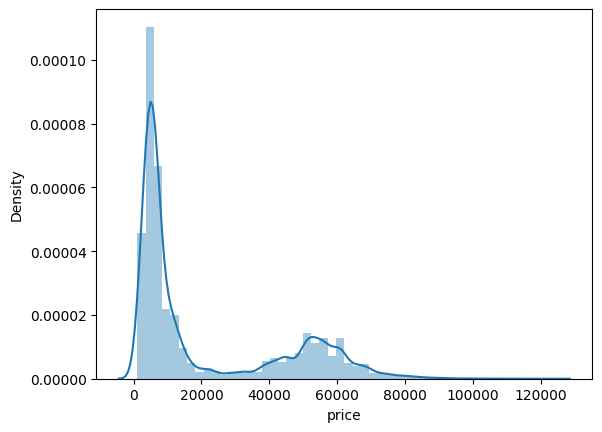

In [ ]:
sns.distplot(df['price'])
plt.show()

In [ ]:
price = df['price']
df.describe()


,stops,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,0.924312,12.221021,26.004751,20889.660523
std,0.398106,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,6.830000,15.000000,4783.000000
50%,1.000000,11.250000,26.000000,7425.000000
75%,1.000000,16.170000,38.000000,42521.000000
max,2.000000,49.830000,49.000000,123071.000000


Można zauważyć, że najwięcej biletów lotniczych jest w cenie ok 10000. Później natępuje drastyczny spadek, jednak przy cenie ok 40 000 ilość biletów wzrasta.  

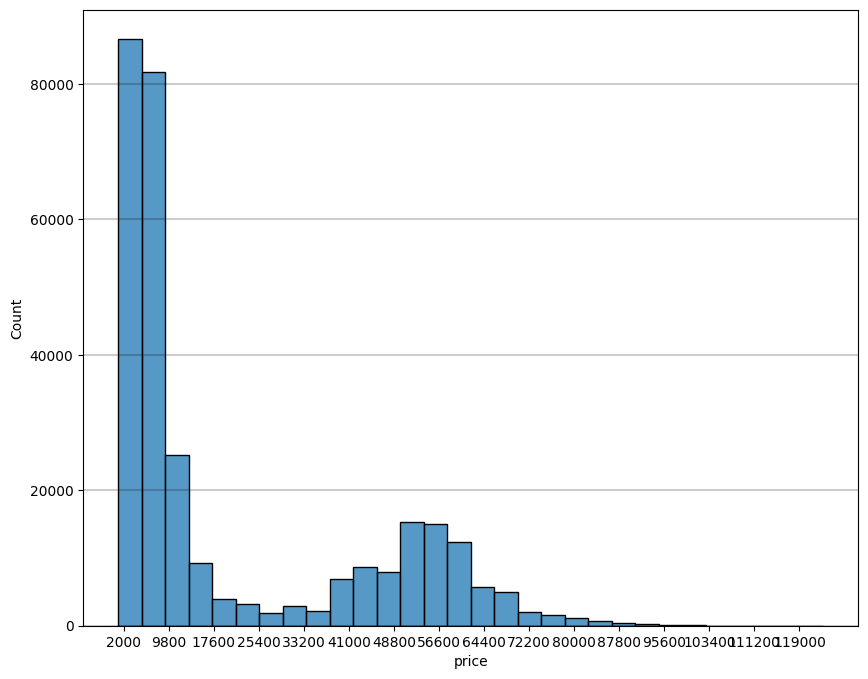

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(df['price'], bins = 30)
ax.set_xticks(np.arange((round(df['price'].min()//1000,0)+1)*1000, (round(df['price'].max()//1000,0)+2)*1000, 7800))
for ytick in range(len(ax.get_yticks())-1):
  plt.axhline(y=ax.get_yticks()[ytick].item(), color='k', linestyle='-', alpha=0.2)
plt.show()

<Axes: xlabel='price'>

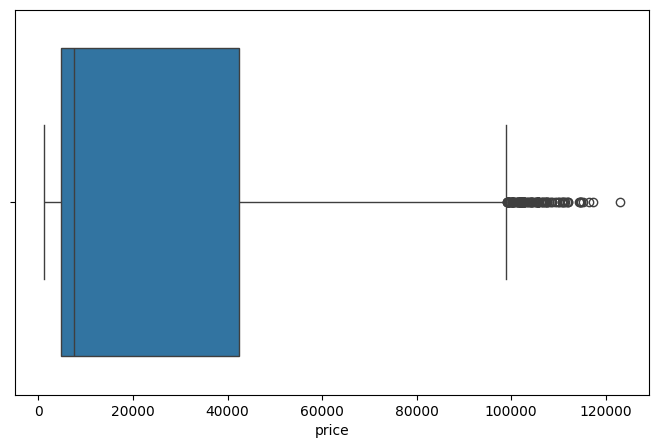

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

Najwięcej sprzedanych biletów oscyluje w przedziale cenowym 10000 - 40000. Istnieją również wartości odstające, które można zauważyć od progu cenowego na poziomie 100000

# Linie lotnicze

Można zauważyć, że najdroższe bilety lotnicze znajdują się w lini lotniczej Vistara, a najtańsze w AirAsia

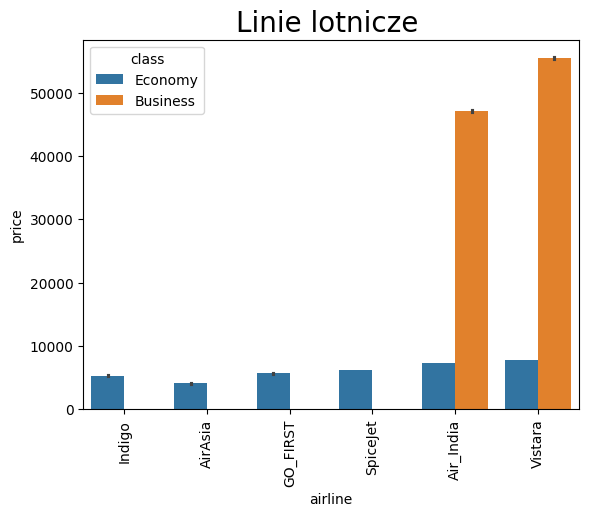

mean           std    min     max
airline   class                                              
AirAsia   Economy    4091.072742   2824.055172   1105   31917
Air_India Business  47131.039212  10521.926556  12000   90970
          Economy    7313.682169   3989.521406   1526   42349
GO_FIRST  Economy    5652.007595   2513.865560   1105   32803
Indigo    Economy    5324.216303   3268.894831   1105   31952
SpiceJet  Economy    6179.278881   2999.630406   1106   34158
Vistara   Business  55477.027777  13225.349062  17604  123071
          Economy    7806.943645   3854.572559   1714   37646

In [ ]:
sns.barplot(x='airline',y='price',hue="class",data=df.sort_values("price")).set_title('Linie lotnicze ',fontsize=20)
plt.xticks(rotation="vertical")
plt.show()
df.groupby(['airline', 'class'])['price'].agg(['mean', 'std', 'min', 'max'])

# Czas odlotu

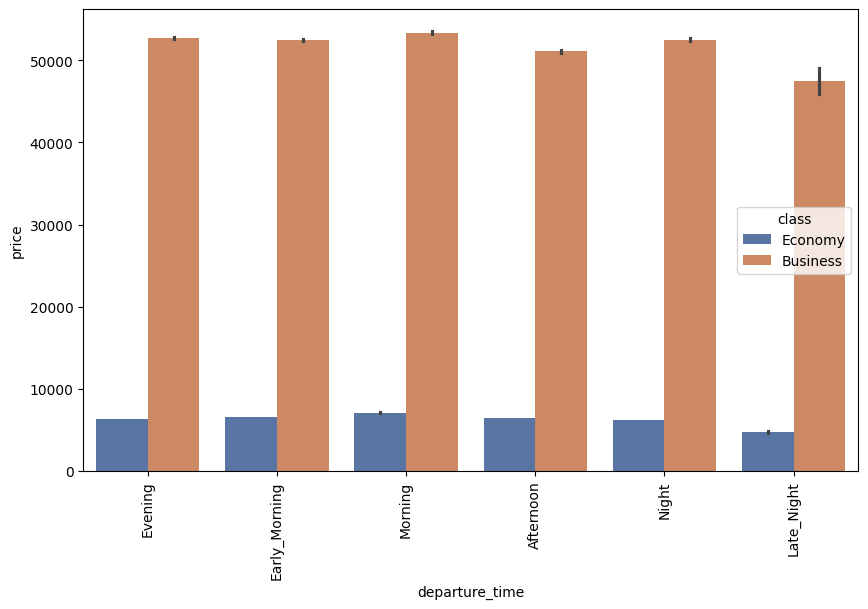

mean           std    min     max
departure_time class                                              
Afternoon      Business  51056.863495  12820.481773  12000  111437
               Economy    6473.095872   3679.728376   1105   40354
Early_Morning  Business  52446.000050  12502.222941  12000  117307
               Economy    6560.315392   3728.931688   1105   36911
Evening        Business  52695.837090  13658.108437  15000  116562
               Economy    6360.750741   3638.498962   1105   42349
Late_Night     Business  47471.971014   9623.259375  25000   56058
               Economy    4784.699486   2388.789076   2050   14526
Morning        Business  53365.483091  13371.151511  12114  123071
               Economy    7119.019664   3992.468173   1105   37646
Night          Business  52512.726456  12130.297972  15000  115211
               Economy    6205.964764   3504.220720   1105   33853

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['departure_time'], y=df['price'], palette='deep', hue="class", data=df.sort_values("price"))
plt.xticks(rotation="vertical")
plt.show()
df.groupby(['departure_time', 'class'])['price'].agg(['mean', 'std', 'min', 'max'])

Widzimy, że czas wylotu nie ma większego znaczenia jeżeli chodzi o ceny biletów lotniczych. Jedynym wyjątkiem są godziny późno-wieczorne gdzie cena spada patrzaąc na klasę biznesową.

# Miejsce odlotu

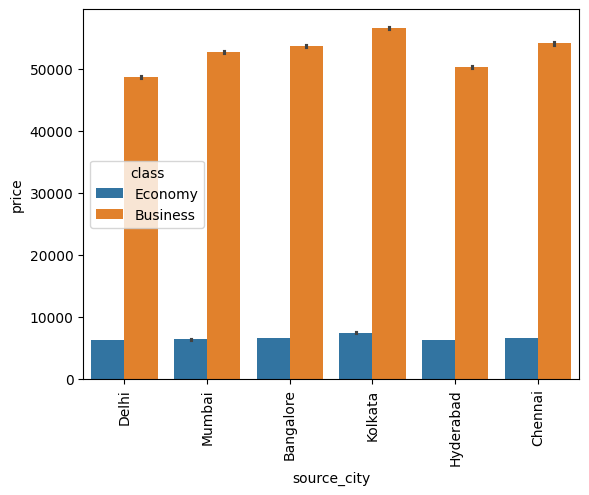

mean           std    min     max
source_city class                                              
Bangalore   Business  53723.539687  12249.652344  12000  111883
            Economy    6582.057019   3694.541962   1603   40354
Chennai     Business  54140.530529  12041.809783  12000  114704
            Economy    6606.279699   4193.299727   1105   42349
Delhi       Business  48697.983457  13165.594844  22152  117307
            Economy    6288.585423   3627.729655   1998   35145
Hyderabad   Business  50370.466200  11629.957988  12114  115211
            Economy    6235.770619   3530.585611   1543   33853
Kolkata     Business  56607.860536  11956.824734  20356  123071
            Economy    7458.632354   3712.278951   2436   34944
Mumbai      Business  52740.521251  14175.358077  17548  114523
            Economy    6358.920050   3654.311949   1890   34188

In [ ]:
sns.barplot(x=df['source_city'], y=df['price'], hue="class", data=df.sort_values("price"))
plt.xticks(rotation="vertical")
plt.show()
df.groupby(['source_city', 'class'])['price'].agg(['mean', 'std', 'min', 'max'])

Można zauważyć, że cena nie będzie zależeć od miejsca przylotu, gdyż i dla klasy ekonomicznej i klasy biznesowej ceny są podobne.

#Miejsce przylotu

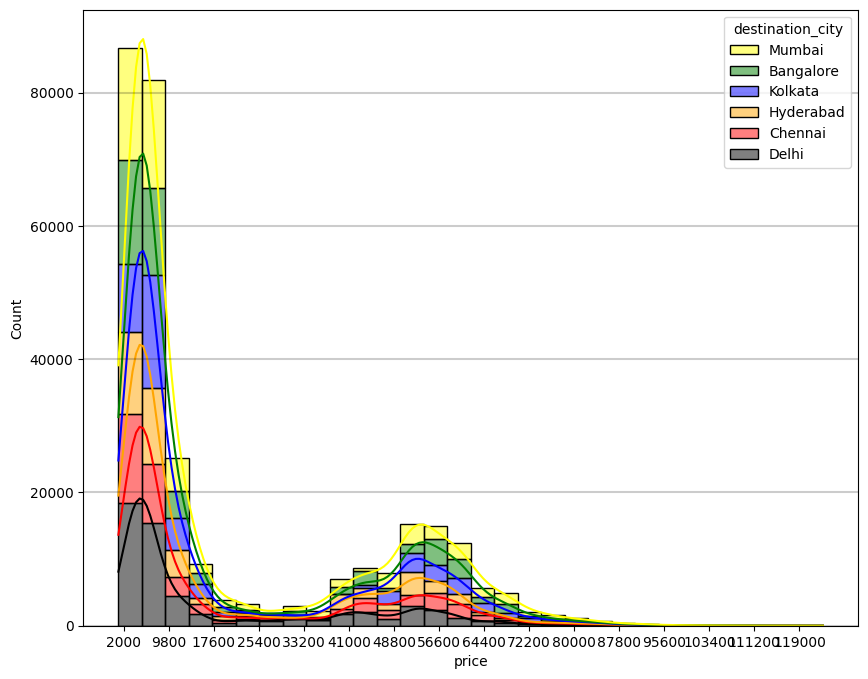

mean           std    min     max
destination_city class                                              
Bangalore        Business  53832.537597  12437.345377  12000  114523
                 Economy    6618.316318   3767.758565   1443   36911
Chennai          Business  53617.092871  11293.040689  12136  111964
                 Economy    6641.605072   4101.255821   1543   35145
Delhi            Business  48088.076914  12997.635643  22140  123071
                 Economy    6251.088579   3589.860388   2051   34968
Hyderabad        Business  50428.510128  11826.886627  12000  114705
                 Economy    6305.544732   3544.789306   1105   30760
Kolkata          Business  56738.007047  11683.037711  20000  117307
                 Economy    7200.518058   3796.530058   2056   42349
Mumbai           Business  52866.332842  14685.598232  17738  115211
                 Economy    6459.578293   3644.455416   1830   40354

In [ ]:
plt.figure(figsize=(10, 8))
my_palette = ['yellow', 'green', 'blue', 'orange', 'red', 'black']
ax = sns.histplot(data=df, x='price', bins=30, kde=True, palette=my_palette, hue='destination_city', multiple='stack')
ax.set_xticks(np.arange((round(df['price'].min()//1000,0)+1)*1000, (round(df['price'].max()//1000,0)+2)*1000, 7800))
for ytick in range(len(ax.get_yticks())-1):
  plt.axhline(y=ax.get_yticks()[ytick].item(), color='k', linestyle='-', alpha=0.2)
plt.show()

df.groupby(['destination_city', 'class'])['price'].agg(['mean', 'std', 'min', 'max'])

Najwięcej sprzedanych biletów jest w najniższej dostępnej cenie czyli do 9800. Rozkład cen jest jednoznacznie prawoskońny, jednak pojawia się delikatny skok w ilości sprzedanych biletów w cenie od 52 000 do 60 000.
Mumbai oraz Bungalore wyróżniają się wysoką liczbą biletów w niższych cenach.
Kolkata widać znaczące skupienie biletów w niższych przedziałach cenowych, ale również wysoką liczbę biletów w przedziałach 40,000-60,000.
Hyderabad i Chennai tak jak w poprzednich kierunkach najwięcej sprzedanych biletów znajduje się w najniższym przedziale cenowym.
Delhi widać że kierunek jest najrzadziej kupowany ze wszytskich podanych, jednak tak jak pozostałe kierunki największą ilość wykazuje w najniższym przedziale cenowym. Jednak analizujac dalsze progi cenowe, ilość zakupionych biletów ulega lekkim odchyleniom.

<Axes: title={'center': 'Średnie ceny w zależności od długości lotu'}, xlabel='duration', ylabel='price'>

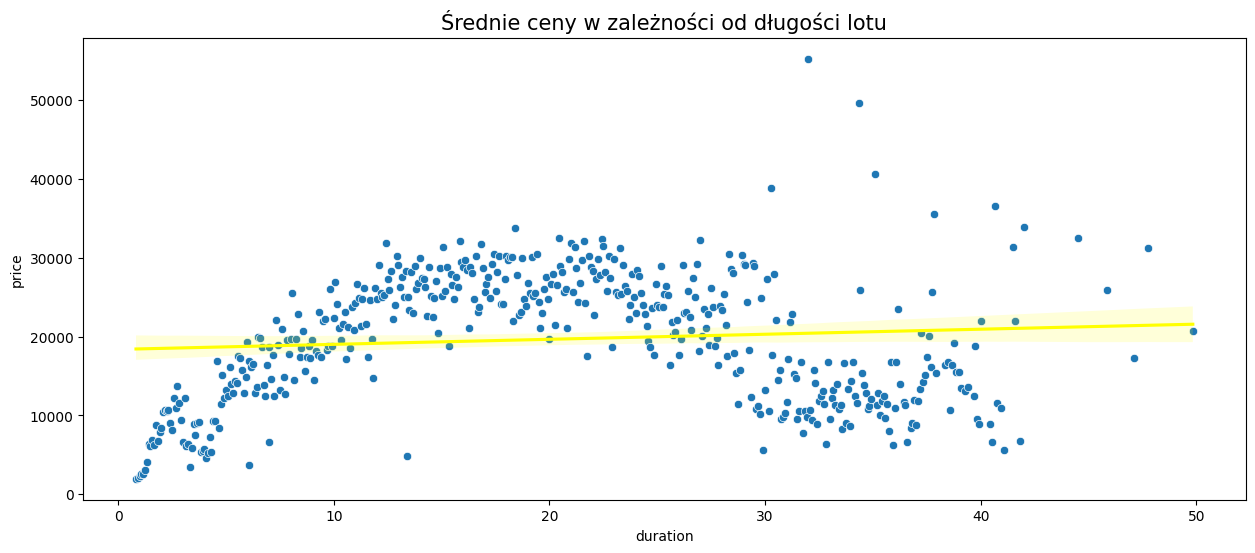

In [ ]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Średnie ceny w zależności od długości lotu",fontsize=15)
sns.regplot(x="duration", y="price", data=df_temp, scatter=False, color='yellow')

# Korelacja

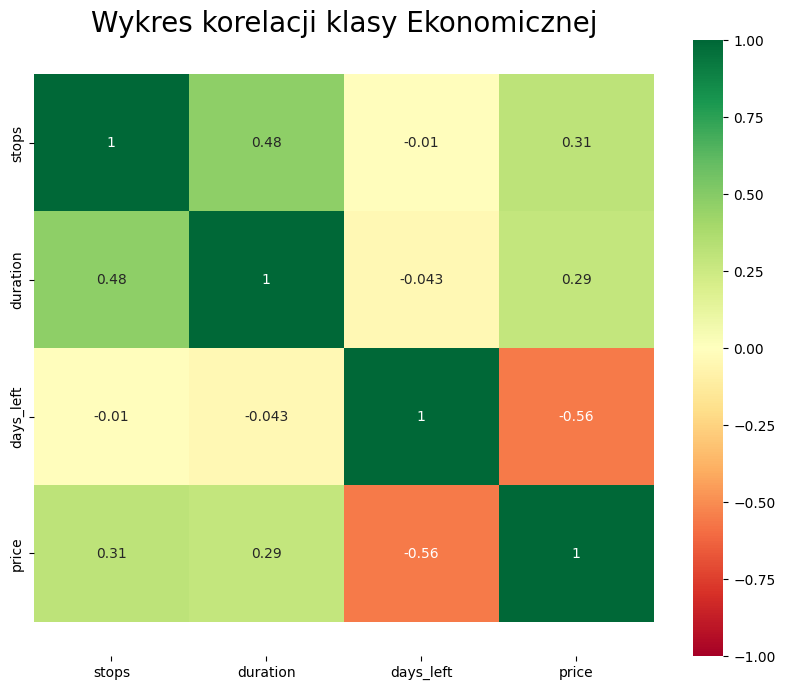

In [ ]:
plt.figure(figsize=(10, 8))
data = df[df['class'] =="Economy"]
ax = sns.heatmap(data.corr(numeric_only = True),
                 xticklabels=data.corr(numeric_only = True).columns,
                 yticklabels=data.corr(numeric_only = True).columns,
                 cmap='RdYlGn',
                 vmin=-1, vmax=1,
                 annot=True, center=0)

plt.title('Wykres korelacji klasy Ekonomicznej', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Na podstawie powyższego wykresu możemy wywnioskować że nie występuje nigdzie silna korelacja między liczbą przesiadek, miejscem przylotu czy liczbą dni do odlotu. Występuje jednak dodatnia korelacja między liczbą przesiadek a ceną oraz kierunkiem a ceną.

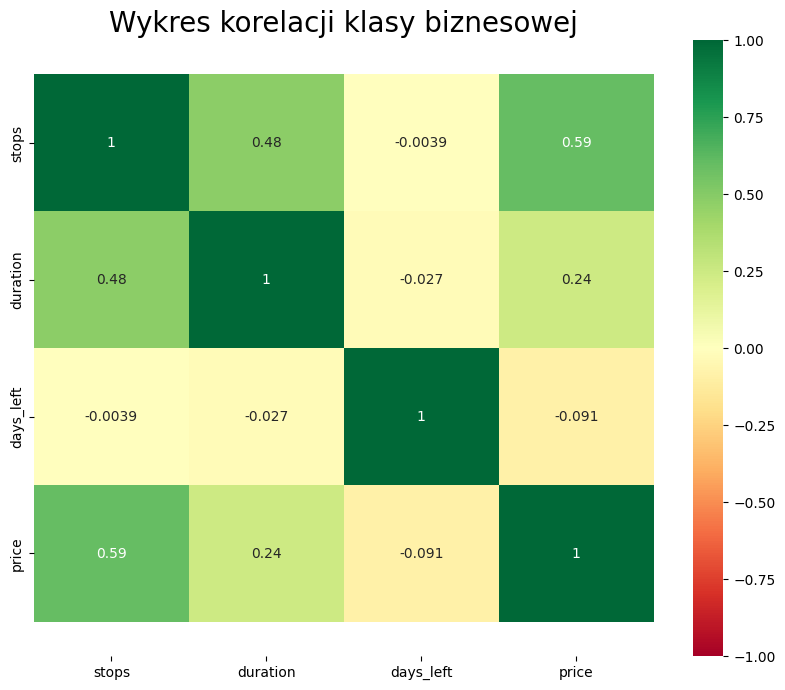

In [ ]:
plt.figure(figsize=(10, 8))
data = df[df['class'] =="Business"]
ax = sns.heatmap(data.corr(numeric_only = True),
                 xticklabels=data.corr(numeric_only = True).columns,
                 yticklabels=data.corr(numeric_only = True).columns,
                 cmap='RdYlGn',
                 vmin=-1, vmax=1,
                 annot=True, center=0)

plt.title('Wykres korelacji klasy biznesowej', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

W klasie biznesowej również nie widzimy silnej korelacji pomiędzy którąkolwiek zmienną. Najwyższą korelację jednak wykanuje zależność ceny od liczby przesiadek, co w późniejszym etapie analizy będzie zauważalne.

# 2. Obróbka danych



* brakujące dane



In [ ]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

Jak można zauważyć, nie ma danych które brakują. Może być to spowodowane już wzceśniej oczyszczonym zbiorem lub wyselekcjonowanymi danymi zebranymi w zbiór, który został użyty.

In [ ]:
df['duration_minutes'] = df['duration'].apply(lambda x: round(x * 60))
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,duration_minutes
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953,130
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953,140
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956,130
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955,135
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955,140
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,1,Evening,Hyderabad,Business,10.08,49,69265,605
300149,Vistara,UK-826,Chennai,Afternoon,1,Night,Hyderabad,Business,10.42,49,77105,625
300150,Vistara,UK-832,Chennai,Early_Morning,1,Night,Hyderabad,Business,13.83,49,79099,830
300151,Vistara,UK-828,Chennai,Early_Morning,1,Evening,Hyderabad,Business,10.00,49,81585,600


In [ ]:
print(df['source_city'].unique())

['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']


In [ ]:
print(df['destination_city'].unique())

['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']


[Delhi: 77°13′E 28°40′N
Mumbai: 19°4.3698′N 72°52.9566′E
Bangalore: 12°58′18″N 77°35′37″E
Kolkata: 22°33′45″N 88°21′46″E
Hyderabad:  17.38405″N, 78.45636″E
Chennai: 13°03′36,34″N 80°14′57,29″E]



In [ ]:
geolocator = Nominatim(user_agent="app")
cities = df['destination_city'].unique()
print(cities)
locations = []

for city in cities:
  location = geolocator.geocode(city+" international airport")
  print(location)
  locations.append((location.latitude, location.longitude))

def get_location(city):
  for i, c in enumerate(cities):
    if c == city:
      return locations[i]


['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
Chhatrapati Shivaji Maharaj International Airport, Road No 4, Prabhat Colony, H/E Ward, Zone 3, Mumbai, Mumbai Suburban District, Maharashtra, 400054, India
Kempegowda International Airport, KIAL Exit Road, Bengaluru, Devanahalli taluku, Bengaluru Rural, Karnataka, 560300, India
Netaji Subhash Chandra Bose International Airport, Old Jessore Road, New Town, Bidhannagar, North 24 Parganas District, West Bengal, 700133, India
Rajiv Gandhi International Airport, Cargo Road, Shamshabad mandal, Ranga Reddy District, Telangana, 509218, India
Chennai International Airport, Grand Southern Trunk Road, CMWSSB Division 201, St. Thomas Mount Cantonment, Alandur, Chennai District, Tamil Nadu, 600027, India
Delhi Bazaar Craft House, T3, Indira Gandhi International Airport Arrival Road, Vasant Vihar Tehsil, New Delhi District, Delhi, 110077, India


In [ ]:
dist = []

def calculate_distance(city1, city2):
  for d in dist:
    if (d[0] == city1 and d[1] == city2) or (d[1] == city1 and d[0] == city2):
      distance = d[2]
      return distance

  coords1 = get_location(city1)
  coords2 = get_location(city2)
  distance = round(geodesic(coords1, coords2).kilometers)
  print(city1, coords1, city2, coords2, distance)
  dist.append((city1, city2, distance))
  return distance
df['distance'] = df.apply(lambda row: calculate_distance(row['source_city'], row['destination_city']), axis=1, result_type='expand')
df

Delhi (28.555524, 77.0851248) Mumbai (19.09015275, 72.86371349380883) 1133
Delhi (28.555524, 77.0851248) Bangalore (13.1976048, 77.7074856433438) 1702
Delhi (28.555524, 77.0851248) Kolkata (22.6564623, 88.44672447479577) 1314
Delhi (28.555524, 77.0851248) Hyderabad (17.231403049999997, 78.4316883457017) 1262
Delhi (28.555524, 77.0851248) Chennai (12.993374, 80.17258667392555) 1753
Mumbai (19.09015275, 72.86371349380883) Bangalore (13.1976048, 77.7074856433438) 833
Mumbai (19.09015275, 72.86371349380883) Kolkata (22.6564623, 88.44672447479577) 1668
Mumbai (19.09015275, 72.86371349380883) Hyderabad (17.231403049999997, 78.4316883457017) 624
Mumbai (19.09015275, 72.86371349380883) Chennai (12.993374, 80.17258667392555) 1033
Bangalore (13.1976048, 77.7074856433438) Kolkata (22.6564623, 88.44672447479577) 1545
Bangalore (13.1976048, 77.7074856433438) Hyderabad (17.231403049999997, 78.4316883457017) 453
Bangalore (13.1976048, 77.7074856433438) Chennai (12.993374, 80.17258667392555) 268
Kolka

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,duration_minutes,distance
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953,130,1133
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953,140,1133
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956,130,1133
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955,135,1133
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955,140,1133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,1,Evening,Hyderabad,Business,10.08,49,69265,605,505
300149,Vistara,UK-826,Chennai,Afternoon,1,Night,Hyderabad,Business,10.42,49,77105,625,505
300150,Vistara,UK-832,Chennai,Early_Morning,1,Night,Hyderabad,Business,13.83,49,79099,830,505
300151,Vistara,UK-828,Chennai,Early_Morning,1,Evening,Hyderabad,Business,10.00,49,81585,600,505


Dodaliśmy:
- przełożenie godzin na minuty
- zmiana miejsc na wspórzędne danych i odległości
- obliczeni dystansu
- obliczenie czasu oczekiwania na przesiadkę

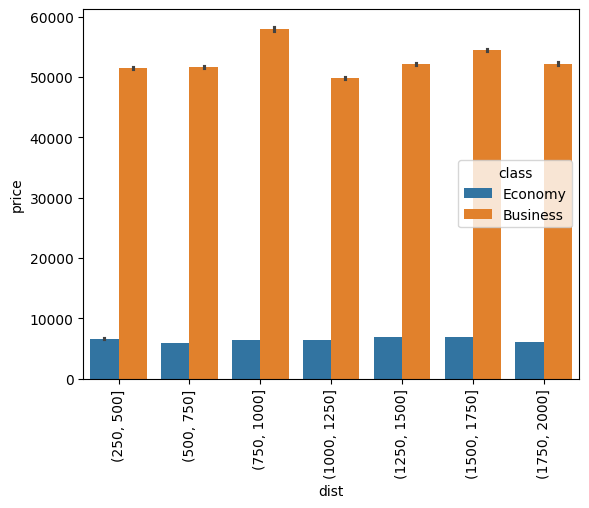

mean           std    min     max
dist         class                                              
(250, 500]   Business  51484.005129  10072.229082  12000  107597
             Economy    6655.188913   4071.469648   1443   36911
(500, 750]   Business  51658.922837  11774.575415  15000  115211
             Economy    5921.499639   3545.396120   1105   32803
(750, 1000]  Business  57997.636179  15614.215713  20684  114523
             Economy    6406.748123   3471.651277   2074   40354
(1000, 1250] Business  49878.372436  13626.418894  20000  114705
             Economy    6429.648221   3867.589262   1830   37646
(1250, 1500] Business  52167.422990  13803.776080  20000  123071
             Economy    6919.642681   3859.177862   2022   42349
(1500, 1750] Business  54437.480791  11492.888197  25000  111883
             Economy    6882.765844   3583.445144   2723   34158
(1750, 2000] Business  52223.787219  12483.448689  27792  104466
             Economy    6089.681516   3533.997128   1998   35145

In [ ]:
df['dist'] = pd.cut(df['distance'], bins=range(250, 2250, 250))
sns.barplot(x=df['dist'], y=df['price'], hue="class", data=df.sort_values("price"))
plt.xticks(rotation="vertical")
plt.show()
df.groupby(['dist', 'class'])['price'].agg(['mean', 'std', 'min', 'max'])

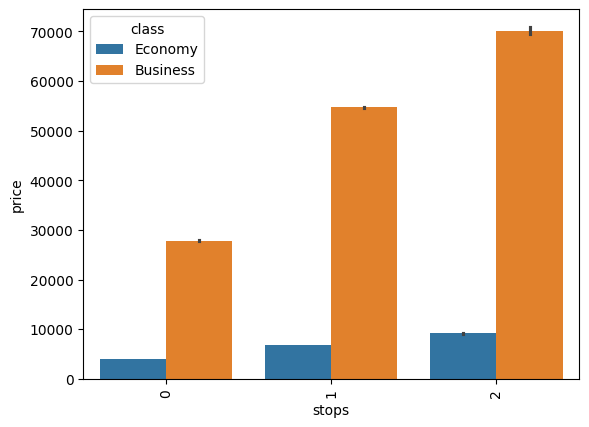

count          mean           std      min      25%  \
airline   class                                                             
AirAsia   Economy   16098.0   4091.072742   2824.055172   1105.0   2361.0   
Air_India Business  32898.0  47131.039212  10521.926556  12000.0  42457.0   
          Economy   47994.0   7313.682169   3989.521406   1526.0   4556.0   
GO_FIRST  Economy   23173.0   5652.007595   2513.865560   1105.0   4205.0   
Indigo    Economy   43120.0   5324.216303   3268.894831   1105.0   3219.0   
SpiceJet  Economy    9011.0   6179.278881   2999.630406   1106.0   4197.0   
Vistara   Business  60589.0  55477.027777  13225.349062  17604.0  49207.0   
          Economy   67270.0   7806.943645   3854.572559   1714.0   5206.0   

                        50%      75%       max  
airline   class                                 
AirAsia   Economy    3276.0   4589.0   31917.0  
Air_India Business  49613.0  54608.0   90970.0  
          Economy    6082.0   9135.0   42349.0  
GO_FIRST  Economy    5336.0   6324.0   32803.0  
Indigo    Economy    4453.0   6489.0   31952.0  
SpiceJet  Economy    5654.0   7412.0   34158.0  
Vistara   Business  56588.0  62591.0  123071.0  
          Economy    6461.0   9945.0   37646.0

In [ ]:
sns.barplot(x=df['stops'], y=df['price'], hue=df['class'])
plt.xticks(rotation="vertical")
plt.show()
df.groupby(['airline', 'class'])['price'].describe()

Można zauważyć, że najwyższe ceny osigają loty z dwoma przesiadkami w klasie biznesowej. W klasie ekonomicznej liczba przesiadek nie odgrywa bardziej znaczącej roli, jednak w biznesowej cena bez przesiadek jet niemal dwa razy niższa niż podczas lotu z dwoma przesiadkami.

<Axes: title={'center': 'Średnie ceny w zależności od długości lotu'}, xlabel='duration', ylabel='price'>

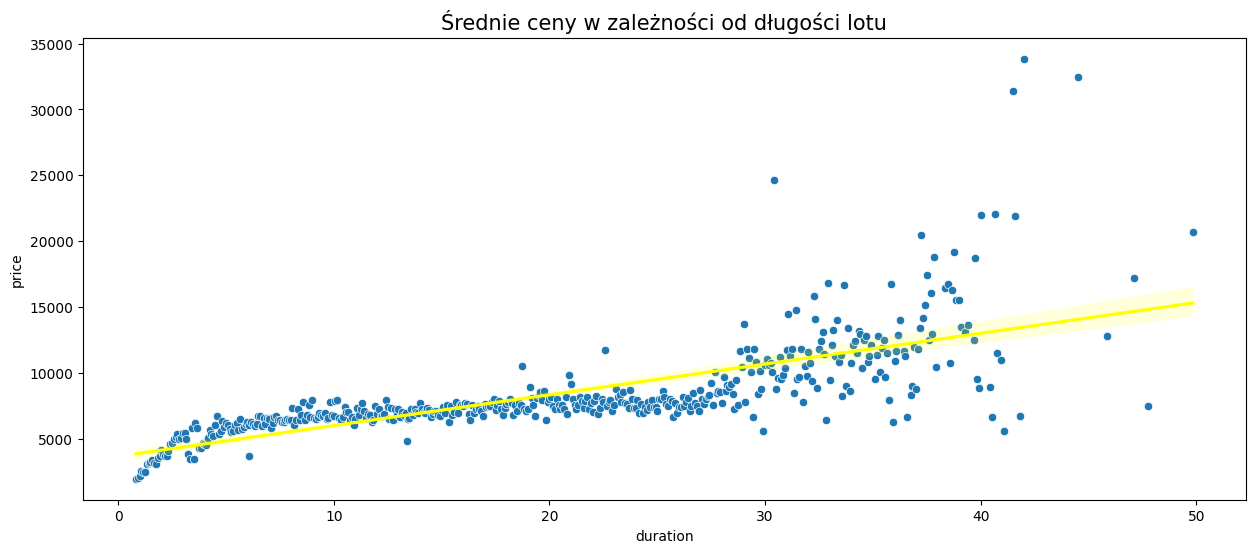

In [ ]:
df_temp = df[df['class']=="Economy"].groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Średnie ceny w zależności od długości lotu",fontsize=15)
sns.regplot(x="duration", y="price", data=df_temp, scatter=False, color='yellow')

<Axes: title={'center': 'Średnie ceny w zależności od długości lotu'}, xlabel='duration', ylabel='price'>

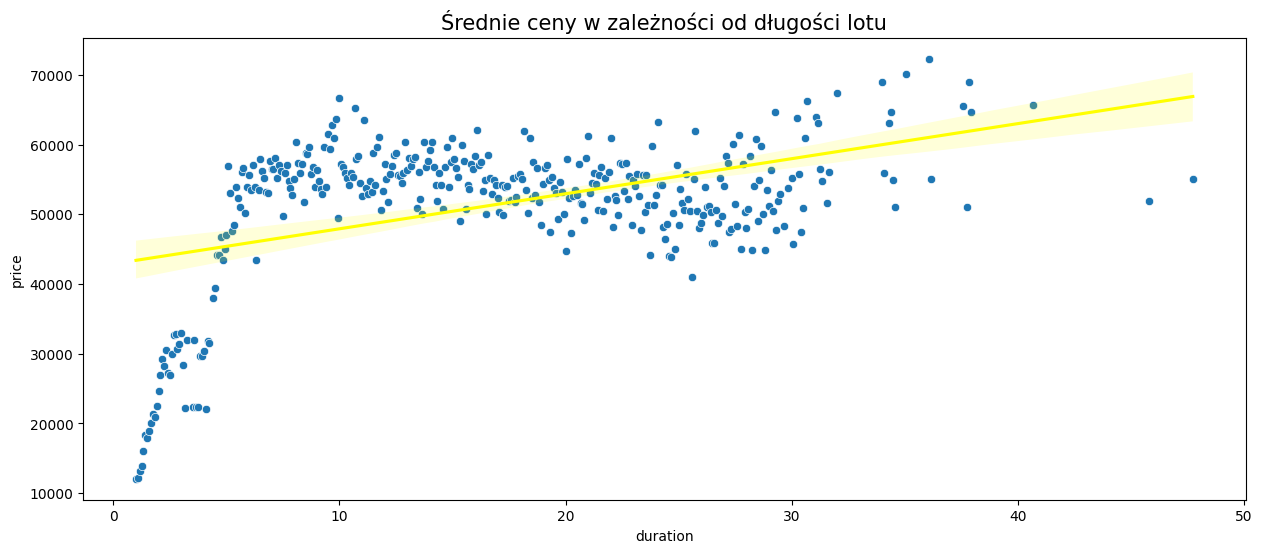

In [ ]:
df_temp = df[df['class']=="Business"].groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Średnie ceny w zależności od długości lotu",fontsize=15)
sns.regplot(x="duration", y="price", data=df_temp, scatter=False, color='yellow')

<Axes: title={'center': 'Średnie ceny w zależności od długości lotu'}, xlabel='days_left', ylabel='price'>

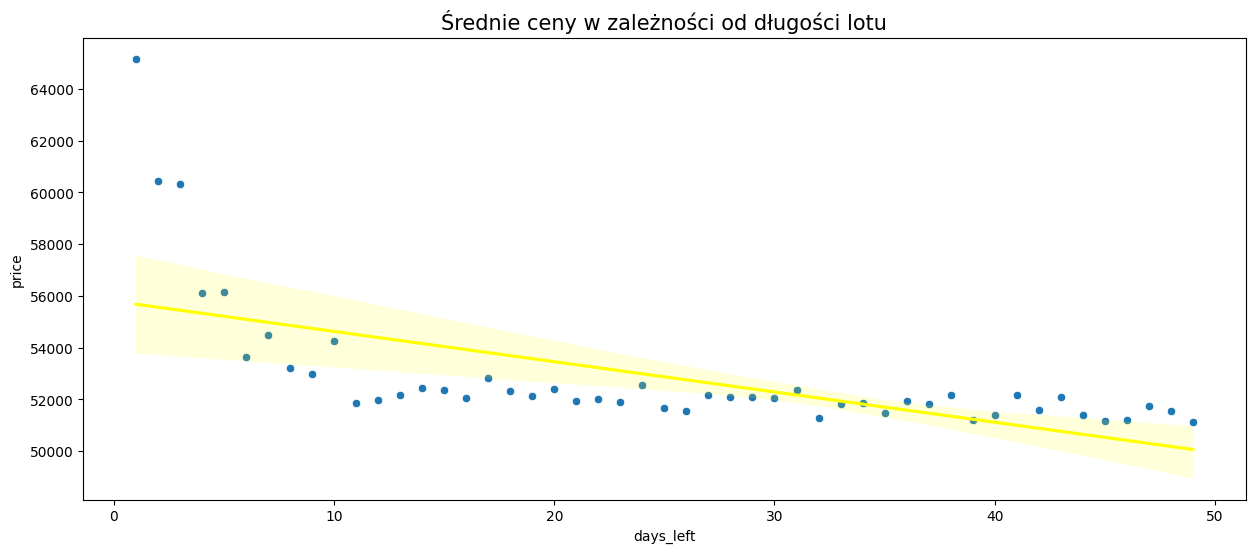

In [ ]:
df_temp = df[df['class']=="Business"].groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Średnie ceny w zależności od liczby dni do wylotu",fontsize=15)
sns.regplot(x="days_left", y="price", data=df_temp, scatter=False, color='yellow')

<Axes: title={'center': 'Ceny w zależności od długości lotu (wyczysczone)'}, xlabel='duration', ylabel='price'>

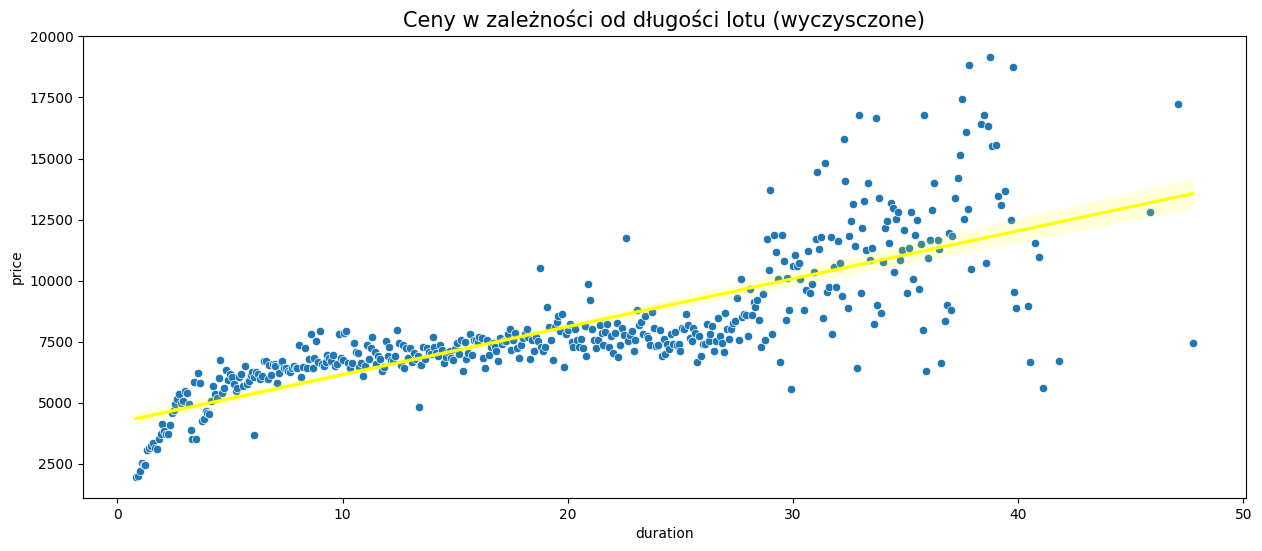

In [ ]:
df_business = df[df['class'] == "Economy"]

df_temp = df_business.groupby(['duration'])['price'].mean().reset_index()

mean = df_temp['price'].mean()
std = df_temp['price'].std()

outliers_mask = (
    (df_temp['price'] < mean - 3 * std) |
    (df_temp['price'] > mean + 3 * std)
)

df_economy_cleaned = df_temp[~outliers_mask]

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_economy_cleaned).set_title("Ceny w zależności od długości lotu (wyczysczone)",fontsize=15)
sns.regplot(x="duration", y="price", data=df_economy_cleaned, scatter=False, color='yellow')

<Axes: title={'center': 'Ceny w zależności od długości lotu (wyczyszczone)'}, xlabel='duration', ylabel='price'>

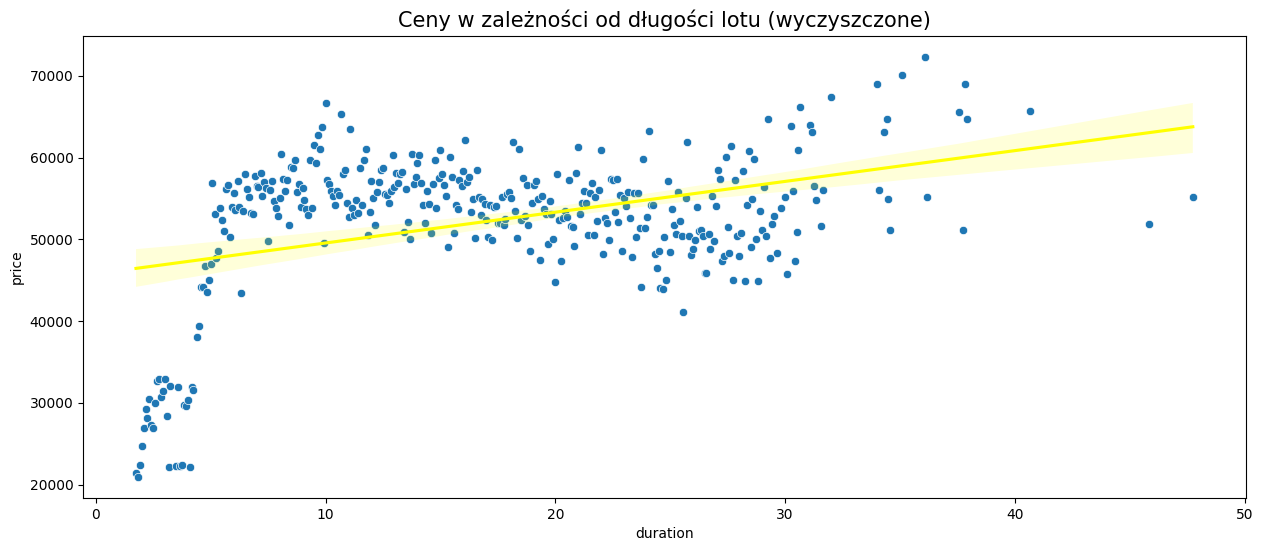

In [ ]:
df_business = df[df['class'] == "Business"]

df_temp = df_business.groupby(['duration'])['price'].mean().reset_index()

mean = df_temp['price'].mean()
std = df_temp['price'].std()

outliers_mask = (
    (df_temp['price'] < mean - 3 * std) |
    (df_temp['price'] > mean + 3 * std)
)

df_business_cleaned = df_temp[~outliers_mask]

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_business_cleaned).set_title("Ceny w zależności od długości lotu (wyczyszczone)",fontsize=15)
sns.regplot(x="duration", y="price", data=df_business_cleaned, scatter=False, color='yellow')

In [ ]:
df_filtered = pd.merge(df_economy_cleaned, df_business_cleaned, on='duration', how='outer')

df_filtered = pd.merge(df, df_filtered, on='duration', how='inner')

df_filtered


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,duration_minutes,distance,dist,price_x,price_y
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953,130,1133,"(1000, 1250]",3728.071405,29272.887166
1,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956,130,1133,"(1000, 1250]",3728.071405,29272.887166
2,Vistara,UK-951,Delhi,Afternoon,0,Evening,Mumbai,Economy,2.17,1,6060,130,1133,"(1000, 1250]",3728.071405,29272.887166
3,GO_FIRST,G8-334,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.17,1,5954,130,1133,"(1000, 1250]",3728.071405,29272.887166
4,Indigo,6E-5001,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.17,1,5955,130,1133,"(1000, 1250]",3728.071405,29272.887166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300138,Air_India,AI-9894,Chennai,Morning,1,Evening,Bangalore,Economy,32.58,9,18063,1955,268,"(250, 500]",12439.833333,NaN
300139,Air_India,AI-569,Chennai,Early_Morning,1,Afternoon,Bangalore,Economy,32.58,10,13653,1955,268,"(250, 500]",12439.833333,NaN
300140,Air_India,AI-569,Chennai,Early_Morning,1,Afternoon,Bangalore,Economy,32.58,16,8760,1955,268,"(250, 500]",12439.833333,NaN
300141,Air_India,AI-9894,Chennai,Morning,1,Evening,Bangalore,Economy,32.58,16,12170,1955,268,"(250, 500]",12439.833333,NaN


<Axes: title={'center': 'Ceny w zależności od długości lotu (wyczysczone)'}, xlabel='duration', ylabel='price'>

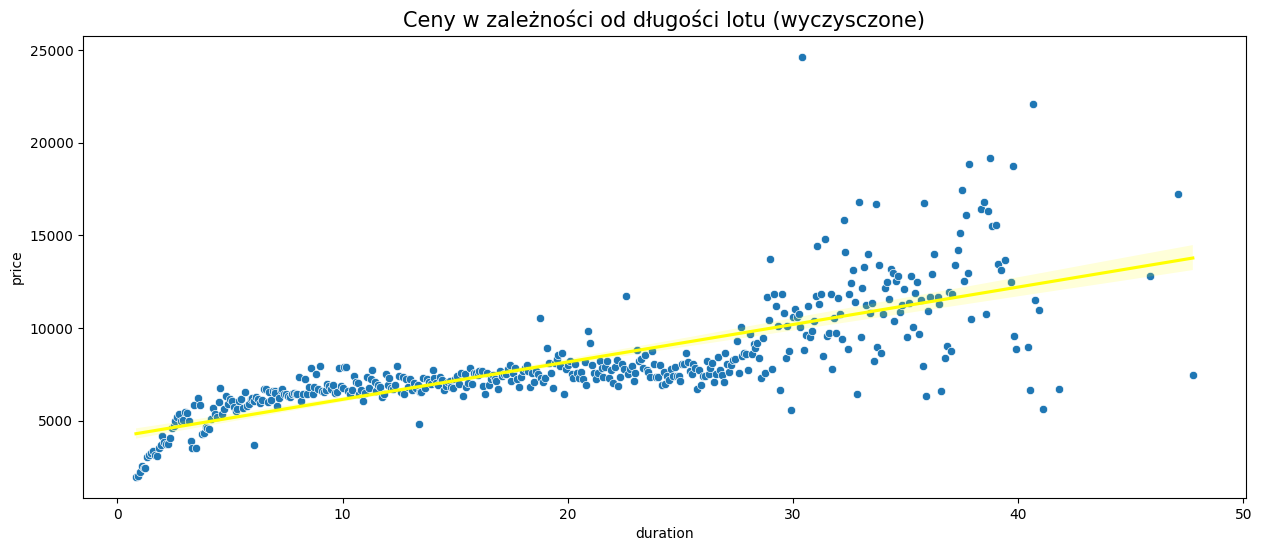

In [ ]:
df_temp = df_filtered[df_filtered['class']=="Economy"].groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Ceny w zależności od długości lotu (wyczysczone)",fontsize=15)
sns.regplot(x="duration", y="price", data=df_temp, scatter=False, color='yellow')

In [ ]:
df_filtered['class'] = df_filtered['class'].replace('Business', True)
df_filtered['class'] = df_filtered['class'].replace('Economy', False)


print(df_filtered['class'].unique())


[False  True]


In [ ]:
df_2 = df_filtered.iloc[:df_filtered.shape[0]//5,:]
df_2

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,duration_minutes,distance,dist,price_x,price_y
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,False,2.17,1,5953,130,1133,"(1000, 1250]",3728.071405,29272.887166
1,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,False,2.17,1,5956,130,1133,"(1000, 1250]",3728.071405,29272.887166
2,Vistara,UK-951,Delhi,Afternoon,0,Evening,Mumbai,False,2.17,1,6060,130,1133,"(1000, 1250]",3728.071405,29272.887166
3,GO_FIRST,G8-334,Delhi,Early_Morning,0,Morning,Mumbai,False,2.17,1,5954,130,1133,"(1000, 1250]",3728.071405,29272.887166
4,Indigo,6E-5001,Delhi,Early_Morning,0,Morning,Mumbai,False,2.17,1,5955,130,1133,"(1000, 1250]",3728.071405,29272.887166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60023,SpiceJet,SG-480,Delhi,Evening,1,Night,Kolkata,False,4.25,21,4417,255,1314,"(1250, 1500]",5682.395604,31531.103448
60024,Indigo,6E-6171,Delhi,Evening,1,Night,Kolkata,False,4.25,21,5955,255,1314,"(1250, 1500]",5682.395604,31531.103448
60025,SpiceJet,SG-480,Delhi,Evening,1,Night,Kolkata,False,4.25,22,4417,255,1314,"(1250, 1500]",5682.395604,31531.103448
60026,Indigo,6E-6171,Delhi,Evening,1,Night,Kolkata,False,4.25,22,5955,255,1314,"(1250, 1500]",5682.395604,31531.103448


Zbiór danych zmiejszyliśmy 5 krotnie w celu usprawnienia obliczeń.

#Podział zbioru na testowy i treningowy - podział losowy 75:25

In [ ]:
X = df_2.drop(columns=['airline', 'arrival_time', 'departure_time', 'source_city', 'destination_city', 'flight', 'dist', 'price_x', 'price_y', 'price'])
y = df_2['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Rozmiar zbioru uczącego:", X_train.shape[0])
print("Rozmiar zbioru testowego:", X_test.shape[0])

Rozmiar zbioru uczącego: 45021
Rozmiar zbioru testowego: 15007


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45021 entries, 27137 to 56422
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stops             45021 non-null  int64  
 1   class             45021 non-null  bool   
 2   duration          45021 non-null  float64
 3   days_left         45021 non-null  int64  
 4   duration_minutes  45021 non-null  int64  
 5   distance          45021 non-null  int64  
dtypes: bool(1), float64(1), int64(4)
memory usage: 2.1 MB


In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)

##3. Opis zastosowanych sieci neuronowych

1. **Typ i architektura sieci**: sieć jednokierunkowa, używana do regresji - feedforward. Stworzono 5 architektu sieci z różną ilością warstw ukrytych oraz różną ilością neuronów. Użyliśmy również sekwencyjnego interfejsu API (Sequential), który składa się z kolejnych warstw.
2.**Ilość epok uczenia:** Każdy model uczy się przez 100 epok.
3.**Sposób uczenia się sieci:** Użyto najbardziej znanej funkcji aktywacji 'ReLU' w przypadku warstw ukrytych. Zastosowano najprostszą warstwę gęstą (dense), dla której wszystkie jednostki poprzedniej warstwy są połączone ze wszystkimi w następnej. Następnie jako algorytm optymalizacji użyto optymalizatora ADAM.
4. **Framework**: Keras, tensorflow, sklearn.


In [ ]:
models = []

## **model 1**
- **typ**: Sequential
-**ilość warstw gęstych:** 3, z czego pierwsza warstwa to warstwa wejściowa i pierwsza warstwa ukryta, a ostatnia warstwa jest warstwą wyjściową z 1 neuronem oraz jest bez aktywacji, co oznacza że będzie używać liniowej funkcji aktywacji. Pierwsza i druga warstwa mają po 128 neuronów oraz aktywację ReLU. Input_shape= X_train.shape[1], - określa liczbę warstw neuronów wejściowych.

In [ ]:
model1 = Sequential()

model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1)
])

print(model1.summary())
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])
models.append(model1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17537 (68.50 KB)
Trainable params: 17537 (68.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#Jak obliczyć wagi?
dense_1: (128+1)*128 = 16 512

dense_2: (128+1)*1 = 129

Total params: 896+16512+12=17537

Czyli powyższa sieć ma do wytrenowania 17 537 parametrów (wag) do wytrenowania.  Liczba parametrów w kolejnej warstwie to liczba wejść z wcześniejszej + wyraz wolny. Warstwy gęste (Dense) polegają na tym, że każda ma połączenie z każdą kolejną warstwą.

## **model 2**
- **typ**: Sequential
-**ilość warstw gęstych:** 4

Pierwsza, druga i trzecia warstwa mają po 64 neurony i aktywację ReLU. Ostatnia warstwa zawiera 1 neuron, bez aktywacji.

In [ ]:
model2 = Sequential()
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

print(model1.summary())
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])
models.append(model2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17537 (68.50 KB)
Trainable params: 17537 (68.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## **model 3**
- **typ**: Sequential
-**ilość warstw gęstych:** 5

Trzy pierwsze warstwy mają po 32 neurony oraz aktywację ReLU, czwarta warstwa ma 64 neurony oraz aktywację ReLU, a ostatna warstwa ma 1 neuron i jest bez aktywacji.

In [ ]:
model3 = Sequential()
model3 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

print(model3.summary())
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])
models.append(model3)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                224       
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## **model 4**
- **typ**: Sequential
-**ilość warstw gęstych:** 4

Pierwsza warstwa ma 32 neurony, druga ma 64 neuronów, trzecia 128, gdzie wszystkie 3 mają aktywację ReLU.

In [ ]:
model4 = Sequential()
model4 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

print(model4.summary())
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])
models.append(model4)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                224       
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10785 (42.13 KB)
Trainable params: 10785 (42.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## **model 5**
- **typ**: Sequential
-**ilość warstw gęstych:** 4

Pierwsza i druga warstwa ma 128 neuronów, obie mają aktywację ReLU. Trzecia wartswa jest warstwą dropout z wartością 0.2 - losowo wyłącza 20% neuronów w czasie trenigu w celu zapobiegania overfittingu. Ostatnia warstwa tak jak poprzednie modele zawiera 1 neuron bez żadnej aktywacji.

In [ ]:
model5 = Sequential()
model5 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

print(model5.summary())
model5.compile(optimizer='adam', loss='mse', metrics=['mae'])
models.append(model5)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               896       
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17537 (68.50 KB)
Trainable params: 17537 (68.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Dla każdego z powyższych modeli wykonano po kolei kompilację, trenowanie, ocenę oraz output wyników.

Model 1
469/469 [==============================] - 1s 1ms/step

DANE TRENINGOWE(UCZĄCE):
Średnia wartość bezwzględna róznicy - MAE 3384.131591796875
Średnia wartość kwadratu różnicy - MSE: 30759390.0
Średni błąd modelu - RMSE: 5546.114856365671
Współczynnik determinacji - R2: 0.9355160507072937

DANE TESTUJĄCE:
Średnia wartość bezwzględna róznicy - MAE 3389.8037109375
Średnia wartość kwadratu różnicy - MSE: 30954298.0
Średni błąd modelu - RMSE: 5563.65868830934
Współczynnik determinacji - R2: 0.935037654216443


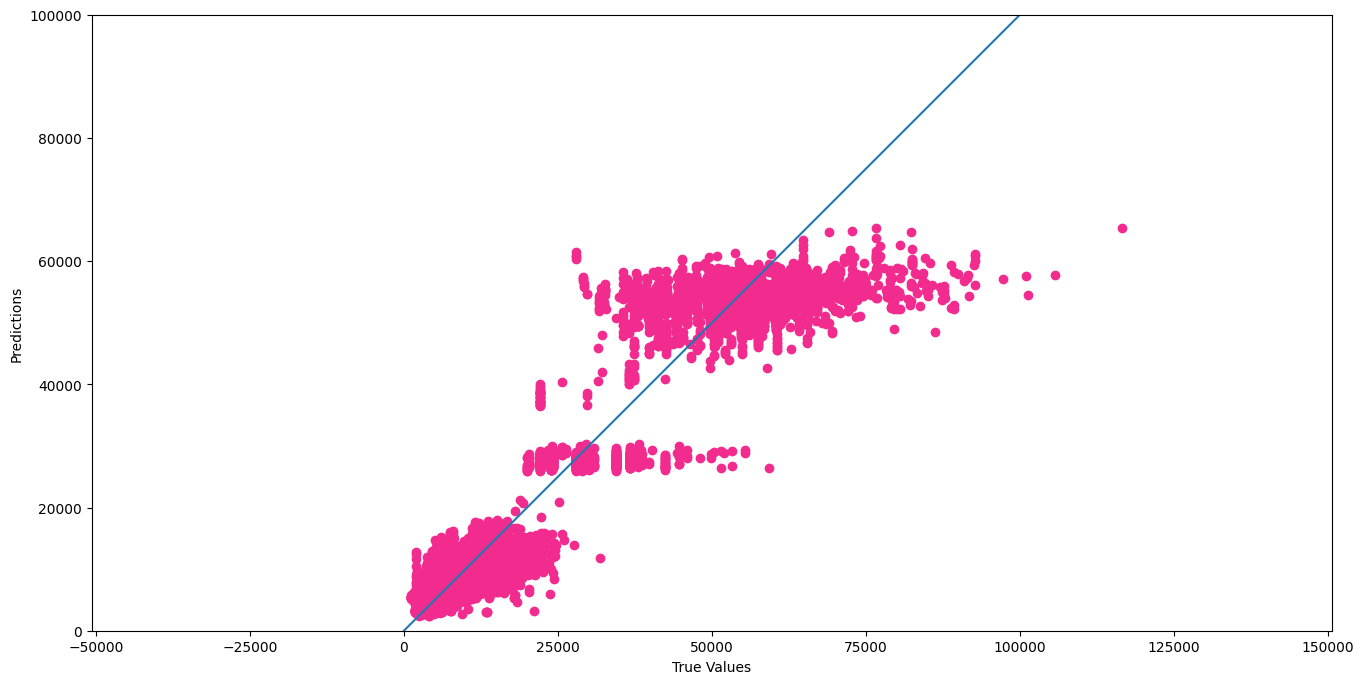

Model 2
469/469 [==============================] - 1s 1ms/step

DANE TRENINGOWE(UCZĄCE):
Średnia wartość bezwzględna róznicy - MAE 3384.131591796875
Średnia wartość kwadratu różnicy - MSE: 30759390.0
Średni błąd modelu - RMSE: 5546.114856365671
Współczynnik determinacji - R2: 0.9376444715165557

DANE TESTUJĄCE:
Średnia wartość bezwzględna róznicy - MAE 3389.8037109375
Średnia wartość kwadratu różnicy - MSE: 30954298.0
Średni błąd modelu - RMSE: 5563.65868830934
Współczynnik determinacji - R2: 0.9371023514189039


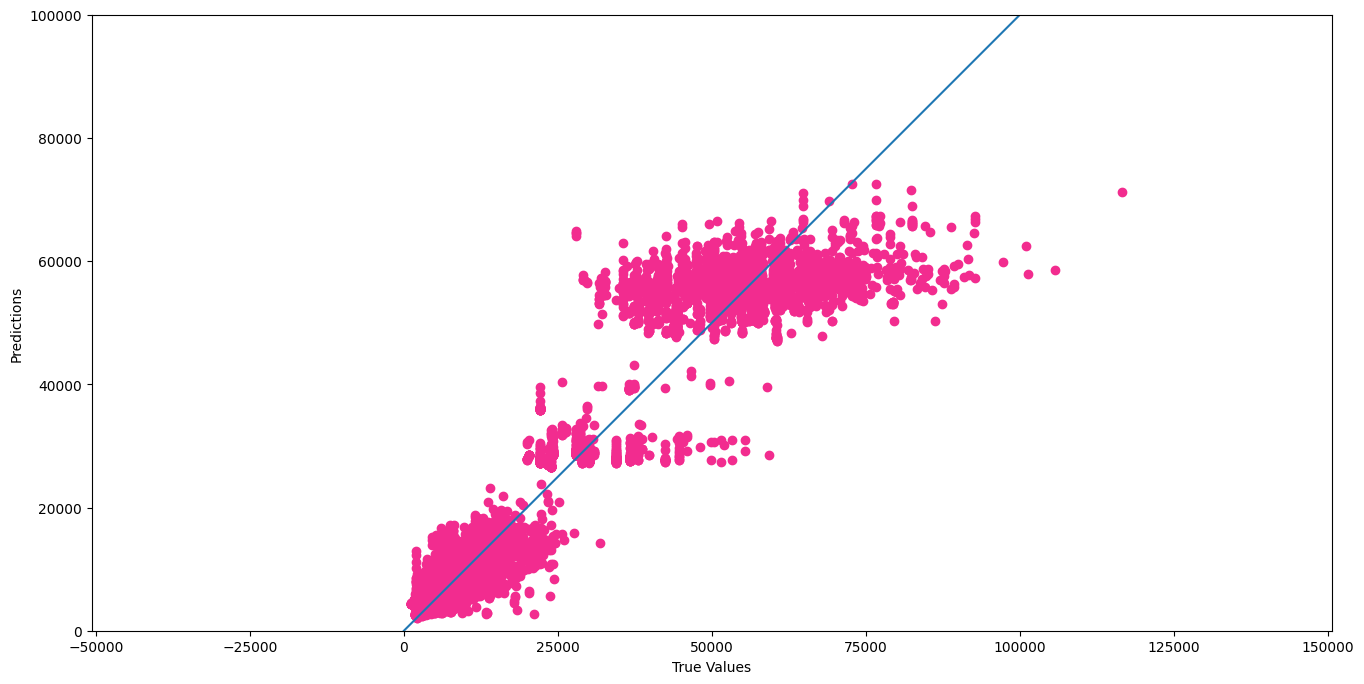

Model 3
469/469 [==============================] - 1s 1ms/step

DANE TRENINGOWE(UCZĄCE):
Średnia wartość bezwzględna róznicy - MAE 3384.131591796875
Średnia wartość kwadratu różnicy - MSE: 30759390.0
Średni błąd modelu - RMSE: 5546.114856365671
Współczynnik determinacji - R2: 0.9321859555078528

DANE TESTUJĄCE:
Średnia wartość bezwzględna róznicy - MAE 3389.8037109375
Średnia wartość kwadratu różnicy - MSE: 30954298.0
Średni błąd modelu - RMSE: 5563.65868830934
Współczynnik determinacji - R2: 0.9316479152154844


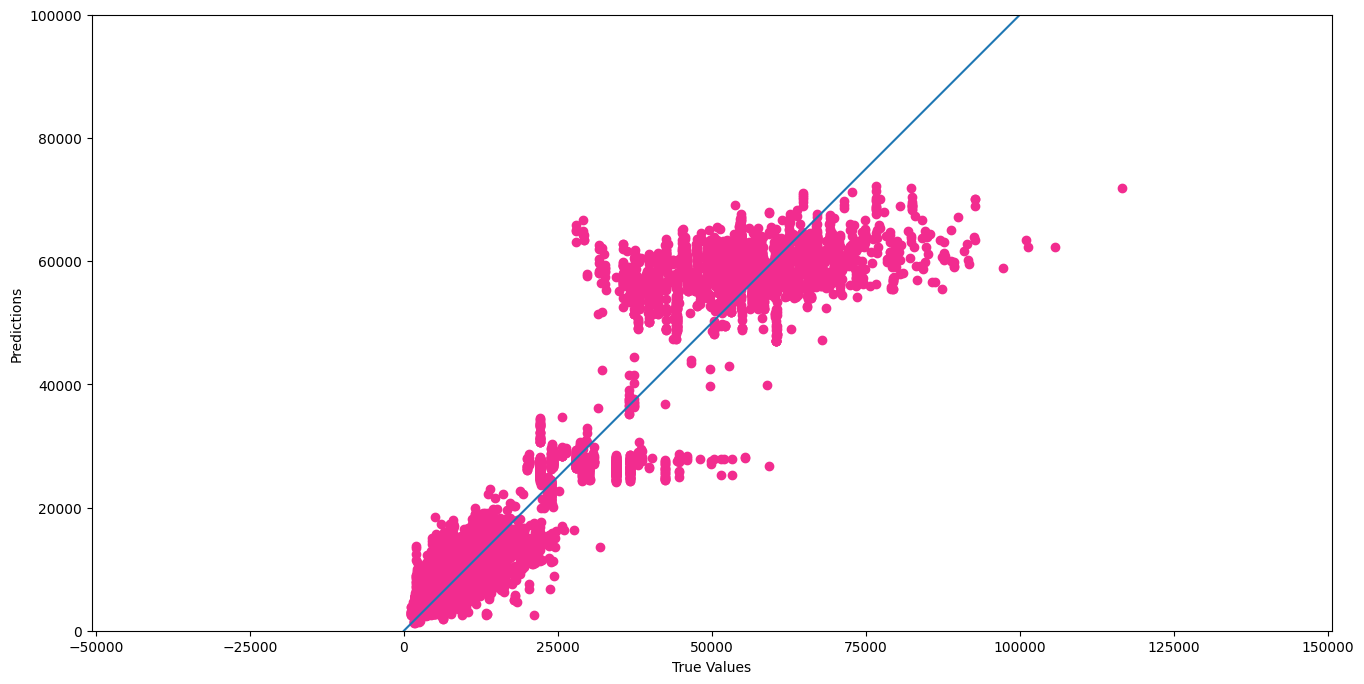

Model 4
469/469 [==============================] - 1s 2ms/step

DANE TRENINGOWE(UCZĄCE):
Średnia wartość bezwzględna róznicy - MAE 3384.131591796875
Średnia wartość kwadratu różnicy - MSE: 30759390.0
Średni błąd modelu - RMSE: 5546.114856365671
Współczynnik determinacji - R2: 0.9347891418172096

DANE TESTUJĄCE:
Średnia wartość bezwzględna róznicy - MAE 3389.8037109375
Średnia wartość kwadratu różnicy - MSE: 30954298.0
Średni błąd modelu - RMSE: 5563.65868830934
Współczynnik determinacji - R2: 0.933592680075283


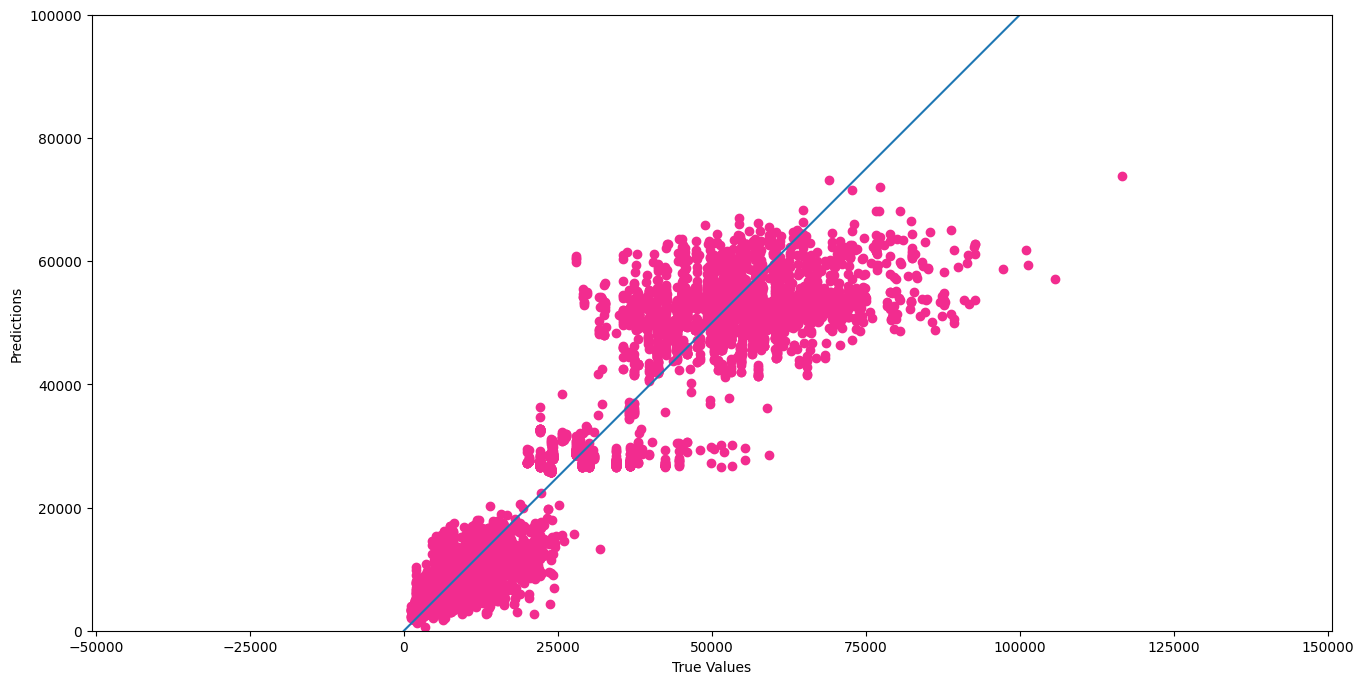

Model 5
469/469 [==============================] - 1s 2ms/step

DANE TRENINGOWE(UCZĄCE):
Średnia wartość bezwzględna róznicy - MAE 3384.131591796875
Średnia wartość kwadratu różnicy - MSE: 30759390.0
Średni błąd modelu - RMSE: 5546.114856365671
Współczynnik determinacji - R2: 0.9300688020891265

DANE TESTUJĄCE:
Średnia wartość bezwzględna róznicy - MAE 3389.8037109375
Średnia wartość kwadratu różnicy - MSE: 30954298.0
Średni błąd modelu - RMSE: 5563.65868830934
Współczynnik determinacji - R2: 0.9303658541138524


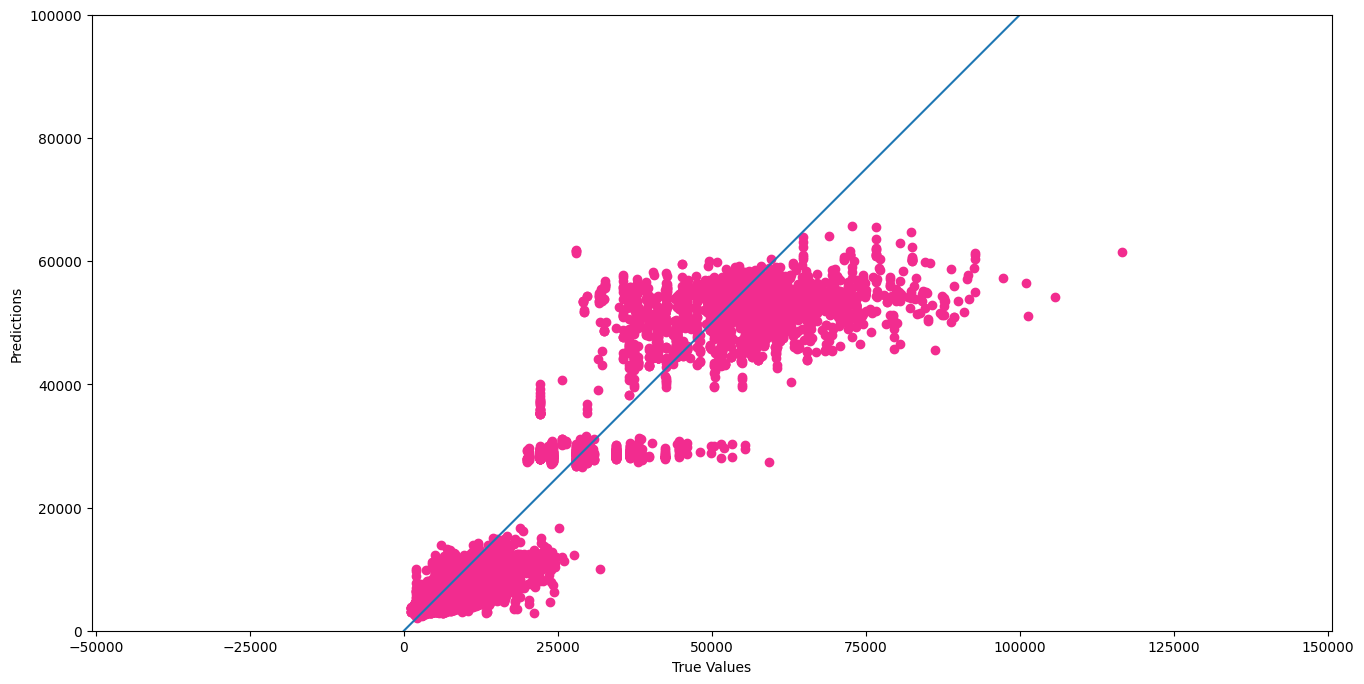

In [ ]:
for i, model in enumerate(models, start=1):
  print(f"Model {i}")

  model.compile(optimizer='adam', loss = 'mse', metrics= ['mae'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.15, verbose=0)

  loss_train, mae_train = model1.evaluate(X_train, y_train, verbose=0)
  loss_test, mae_test = model1.evaluate(X_test, y_test, verbose=0)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  print("\nDANE TRENINGOWE(UCZĄCE):")
  print('Średnia wartość bezwzględna róznicy - MAE', mae_train)
  print('Średnia wartość kwadratu różnicy - MSE:', loss_train)
  print('Średni błąd modelu - RMSE:', np.sqrt(loss_train))
  print('Współczynnik determinacji - R2:', r2_score(y_train, y_pred_train))

  print("\nDANE TESTUJĄCE:")
  print('Średnia wartość bezwzględna róznicy - MAE', mae_test)
  print('Średnia wartość kwadratu różnicy - MSE:', loss_test)
  print('Średni błąd modelu - RMSE:', np.sqrt(loss_test))
  print('Współczynnik determinacji - R2:', r2_score(y_test, y_pred_test))


  plt.figure(figsize=(16, 8))
  plt.scatter(y_test, y_pred_test, color='#f22c8f')
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(0, 100000)
  plt.ylim(0, 100000)
  _ = plt.plot([0, 100000], [0, 100000])
  plt.show()

##4. Dyskusja wyników oraz wnioski

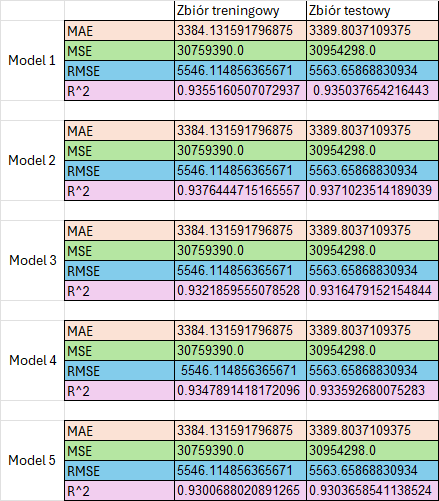

##Wnioski

Można zauważyć, że wszytkie modele mają w przybliżeniu takie same wyniki jeżeli chodzi o wartości MAE, MSE oraz RMSE zarówno dla zbioru treningowego jak i testowego. Wszystkie modele osiągnęły bardzo wysokie wartości R², co oznacza, że modele są dobrze dopasowane do danych. MAE i RMSE są również stosunkowo niskie, co wskazuje na dobrą jakość predykcji. Można zauważyć, że najlepsze dopasowanie ma model 2, ponieważ ma najwyższy współczynnik determinacji (R²) dla zbioru testowego oraz treningowego. Wysoki współczynnik determinacji oznacza, że model lepiej wyjaśnia wariancję danych, co wskazuje na lepsze dopasowanie do rzeczywistych wartości. Jednak patrząc na wartości MAE, MSE oraz RMSE można zauważyć, że są one stałe, jednak różnią się współczynnikami determinacji. Model 5 ma najniższe wartości R² zarówno dla danych treningowych, jak i testowych, co wskazuje na najsłabsze dopasowanie do danych. Na podstawie wyników, można wywnioskować, że dla dużego zbioru danych, jaki jest wykorzystywany w tym przypadku, wybór modelu nie wpływa znacząco na uzyskane wyniki predykcji.

#Dalszy rozwój projektu
- przetestowanie nowych modeli regresji takich jak XGBoost i porównanie ich wartości,
- przeprowadzenie walidacji krzyżowej, która oceni wydajność modelu i polega na takim podziale obiektów pomiędzy zbiór uczący i zbiór testowy, aby zachowane były oryginalne proporcje pomiędzy klasami decyzyjnymi,
- optymalizacja architektury sieci neuronowej poprzez zmianę liczby warstw czy neuronów.